In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Defining Variables

In [2]:
r_planet = 300000 # m
core_size_factor = 0.65 # fraction of total radius 
r_core = (r_planet)*core_size_factor # m
dr = 1000 # m

temp_init = 1600 # K
temp_surface = 250 # K
temp_core_melting = 1200 # K

reg_thickness = (0.04*r_planet)*2 # m

core_density = 7800 # kg/m^3
olivine_density = 3300 # kg/m^3
olivine_cp = 600 # J/kg/K
core_cp = 850 # J/kg/K
core_latent_heat = 270000 # J/kg
cmb_conductivity = 3.0 # W/m/K 

max_time = 400 # million years

# setting suitable max times for certain radii
if r_planet == 100000:
    max_time = 150 # Myr
if r_planet == 200000:
    max_time = 400
if r_planet == 300000:
    max_time = 600


max_time = max_time * 1000000 * 365 * 24 * 3600 #sec

timestep = 2E11 # sec

## Defining Variable Arrays 

In [3]:
# set up arrays for the core and the mantle 
radii = np.arange(r_core, r_planet, dr)
core = np.arange(0, r_core-dr+0.5*dr, dr)  

# Set list of timesteps
times = np.arange(0, max_time+0.5*timestep, timestep)

In [4]:
# Temperature array
temperatures = np.zeros((radii.size, times.size))

# Core temperature array
coretemp = np.zeros((core.size, times.size))

#thermal conductivity array
thermal_conductivity = np.zeros((radii.size, times.size))

#dT/dr array
dT_by_dr = np.zeros((radii.size, times.size))

#Arrays for temperature terms above and below debye
T_above_debye = np.zeros((radii.size, times.size))
T_below_debye = np.zeros((radii.size, times.size))

#Courant number array
courant = np.zeros((radii.size, times.size))

#empty list of latent heats 
latent =[]



## Temperature Timestepping 

In [5]:
#funtion to deal with divide by 0 errors
#computes x/y, if y=0 it outputs 0. If y>0 it computes x/y as normal
def div_0(x, y):
    if y == 0:
        return 0 
    else:
        return (x / y)**(3/2)

# initial temperautres and conditions
temperatures[:,0] = temp_init
temperature_core = temp_init
coretemp[:,0] = temp_init
max_core_lh = 4.0/3.0 * np.pi * (r_core**3) * core_density * core_latent_heat
core_lh_extracted = 0.0

#constant 'a' from differentiating the kappa-T relationship
a = -38.71
#Constant for below debye temperature (set at this value to match order of magnitude of conductivity after debye)
a_2 = 0.0000001

i = 1
for i in range(1, len(times[1:])+1):      
    t = times[i]
    for j in range(1, len(radii[1:-1])+1):       
        r = radii[j]
        
                            #This is the (dT/dr) finite difference equation  
        dT_by_dr[j,i] =  (((temperatures[j+1, i-1])-(temperatures[j-1,i-1]))/(2*dr))
        
        #set all very small values of dT/dr to 0 to avoid overflow error when squared
        if (abs(dT_by_dr[j,i])) <= 1E-7:
            dT_by_dr[j,i] = 0
        else:
            pass       
        
        #create new term for (dT/dr)^2 now that small values are eliminated
        dT_by_dr_squared = (dT_by_dr[j,i])**2
        
        #Create the extra terms that need to be introduced, both above and below the debye temperature       
        #above debye
        if temperatures[j,i-1] >= 673:  
            T_above_debye[j,i-1] = ((temperatures[j,i-1])) #Just defines T for use later
            T_below_debye[j,i] = 0 #above debye temp this extra term is 0
            thermal_conductivity[j,i] = (4.485*(((298/(temperatures[j,i-1])))**0.5))#conductivity expression for T>debye
            
        #below debye    
        else:                 
            T_above_debye[j,i-1] = 0 #below debye this extra term is 0 
            T_below_debye[j,i] = ((temperatures[j,i-1])) #Just defines T for use later
            thermal_conductivity[j,i] = ((6.589203095220635E-6)*((temperatures[j,i-1])**2)) #+1.27 to link curve to after debye
            
        #Complete the extra term above debye: timestep*-38.71*(1/T)^(3/2)*(dT/dr)^2 from differentiating kappa-T
        dK_by_dT_above_debye = (timestep)*(-36.25)*((div_0(1,T_above_debye[j,i-1])))
        
        #complete the extra term below debye: 2T
        dK_by_dT_below_debye = (timestep)*a_2*2*T_below_debye[j,i] #(dK/dT) for K proportional to T^2 = 2T
        dT = (temperatures[j+1,i-1]-temperatures[j-1,i-1]) #difference between successive temperatures
        d2T = (temperatures[j+1,i-1] - 2.0*temperatures[j,i-1] + temperatures[j-1, i-1])  #top of d^2T/dr^2
        
        R = radii[j] # defines current radius
        
        current_T = temperatures[j, i-1] # defines current temperature
        
        rho_cp = ((olivine_density*olivine_cp)) #defines a term for rho_cp to convert conductivity to diffusivity
         
        #define thermal diffusity = thermal conductivity/ rho_cp
        # If the radius is within regolith then divide thermal diffusitiy by a factor of 10 
        if r_planet - R < reg_thickness:
            thermal_diffusivity = ((thermal_conductivity[j,i])/(rho_cp))/10
        else:
            thermal_diffusivity = (thermal_conductivity[j,i])/(rho_cp)
        
        #keep track of courant number (should be less than 0.5 for stability)
        courant[j,i] = ((thermal_diffusivity)*(timestep))/(dr**2) 
        if courant[j,i] >= 0.5:
            print("Courant too high")
        else:
            pass
        
                
        #now do the temperature timestepping       
        temperatures[j,i] = (thermal_diffusivity)  * timestep * ((dT/(R*dr)) +(d2T/dr**2)) + current_T \
            + (((dK_by_dT_above_debye)*(dT_by_dr_squared) + ((dK_by_dT_below_debye)*(dT_by_dr_squared)))/rho_cp)
            
    #set top and bottom temperatures as fixed
    temperatures[-1,i] = temp_surface
    temperatures[0,i] = temperature_core
    coretemp[:,i] = temperatures[0,i]
    
    # Cool the liquid or the solid   
    if (temperature_core > temp_core_melting) or (core_lh_extracted >= max_core_lh):
       
        temperature_core = temperature_core - (3*cmb_conductivity * ((temperatures[0,i]-temperatures[1,i])/dr) * timestep) \
                           / (core_density * core_cp * r_core)
          
    else:
        
        core_lh_extracted = core_lh_extracted + (4.0*np.pi*r_core**2) * cmb_conductivity * \
            ((temperatures[0,i]-temperatures[1,i])/dr) * timestep
        latent.append(core_lh_extracted) #add to the latent heat list for each timestep while core solidifies


## Checking Thermal Conductivity Behaves as Expected

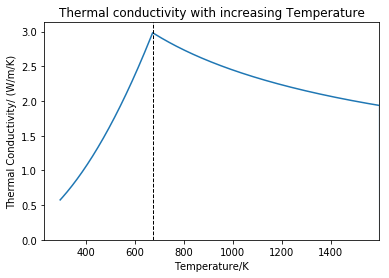

Maximum thermal conductivity: 2.98444129092
Minimum thermal conductivity: 1


In [6]:
#check that thermal conductivity is behaving as expected
plt.plot(temperatures[-10,:], thermal_conductivity[-10,:]) #-10 is a location somewhere near the top of the mantle
plt.ylim(ymin=0)
plt.xlim(xmax=1597)
plt.xlabel("Temperature/K")
plt.ylabel("Thermal Conductivity/ (W/m/K)")
plt.title("Thermal conductivity with increasing Temperature")
plt.axvline(x=673, color='k', linestyle='--', label='label', linewidth = 1)
plt.show()

max_kappa = np.amax(thermal_conductivity)
print("Maximum thermal conductivity:", max_kappa)
min_kappa = np.amin(np.nonzero(thermal_conductivity))
print("Minimum thermal conductivity:", min_kappa)

## Finding the Timing of Core Solidification

In [7]:
#finding time where the core starts to freeze
core_frozen = [coretemp<=1200]  #creates boolean array for temp<=1200
times_frozen = np.where(core_frozen)[2] #np.where outputs indices where temp<=1200

time_core_frozen = 0
if time_core_frozen>=max_time or len(times_frozen) == 0:
    print('Core freezes after max time')
    time_core_frozen = 0
    fully_frozen = 0
else:
    time_core_frozen = times_frozen[0] #first time the temperatrure is less than 1200K
    time_core_frozen = (time_core_frozen)*(10**11) #convert to seconds

#find time core finishes freezing, time when latent heat is all gone + time core started to freeze
fully_frozen = times[len(latent)] + time_core_frozen

## Differentiation of Temperatures

In [8]:
#calculate rate of change of temperatures
dT_by_dt = np.gradient(temperatures, timestep, axis=1)
dT_by_dt_core = np.gradient(coretemp, timestep, axis=1)

## Function to Compute the Depth of Formation based on the Cooling Rates

In [9]:
#funtion finding the depth, given the cooling rate, and checks if the 593K contour crosses this depth during core solidification
def Critical_Depth(CR): 
    #Define two empty lists 
    t_val = [] #for the 800K temperature contour
    dt_val = [] #cooling rate contour
    for ti in range(5,temperatures.shape[1]):
        
        #Find the index where temperatures are 800K by finding the minimum of (a given temperature-800)
        index_where_800K_ish = np.argmin(np.absolute(temperatures[:,ti] - 800))
        if (np.absolute(temperatures[index_where_800K_ish,ti] - 800)) > 10: 
            continue
            
        #Find the index where dT_by_dt = meteorite cooling rate
        index_where_dtbydT = np.argmin(np.absolute(dT_by_dt[:,ti] + CR ))
        if (np.absolute(dT_by_dt[index_where_dtbydT,ti] + CR)) > 1E-15:
            continue
            
        t_val.append(index_where_800K_ish)
        dt_val.append(index_where_dtbydT)
        
    #Find the points where they cross, this will lead to a depth
    assert len(t_val) == len(dt_val), "Contour length error!" # flags an errror if t_val and dt_val are not the same length 
    
    crosses = np.array(t_val) - np.array(dt_val) == 0 # boolean for if the indecies of the two arrays are the same 
    if not any(crosses):
        # The two lines do not cross
        x = "No cooling rate matched cooling history"
        return None, x, None, None, None
    
    
    crossing_index2 = np.argmax(crosses) # finds the first 'maximum' which is the first TRUE, or the first crossing
    Critical_Radius = radii[dt_val[crossing_index2]] #radius where this first crossing occurs
    
    t_val2 = [] #for the 593K contour
    d_val = [] #depth 
    for ti in range(5,temperatures.shape[1]):
        #Find the index where temperatures are 593K by finding the minimum of (a given temperature-593)
        index_where_593K_ish = np.argmin(np.absolute(temperatures[:,ti] - 593))
        if (np.absolute(temperatures[index_where_593K_ish,ti] - 593)) > 10:
            pass
        
        t_val2.append(index_where_593K_ish)
        d_val.append((Critical_Radius)/1000 - ((r_planet/1000)*core_size_factor)) #computes the depth 
        
    crossing = [np.array(t_val2) - d_val == 0] #indicies where computed depth crosses temperature contour 
    crossing_index = np.argmax(crossing) # finds the first 'maximum' which is the first TRUE, or the first crossing
    Time_of_Crossing = crossing_index*(10**11) #converts to seconds
    radii_index = int(((d_val)[crossing==True]))
    
    #check to see if the depth crosses the 593K contour during solidification or before/after
    if time_core_frozen == 0:
        x= 'Core Freezes after Max Time' 
        depth = ((r_planet) - radii[int(((d_val)[crossing==True]))])/1000
        return (depth, x, time_core_frozen, Time_of_Crossing)
    else:
        if radii_index > len(radii):
            x= 'Core has finished solidifying'
            depth = 0
            return (depth, x, time_core_frozen, Time_of_Crossing)
        else:
            depth = ((r_planet) - radii[int(((d_val)[crossing==True]))])/1000
            if Time_of_Crossing == 0:
                x='hmm, see plot' #lines cross at 0 time
            if Time_of_Crossing < time_core_frozen and Time_of_Crossing!=0:
                x = 'Core has not started solidifying yet'
            if time_core_frozen < Time_of_Crossing < fully_frozen:
                x= 'Core has started solidifying'
            if Time_of_Crossing > fully_frozen:
                x= 'Core has finished solidifying'
    
            return (depth, x, time_core_frozen, Time_of_Crossing, Critical_Radius) 


## Calculation of Cooling Rates and Depths

In [10]:
#Calculate Imilac Cooling Rate using equation from yang et al 2010
# d^2.9 = m/CR 
m = 7620000 #constant from yang et al 2010
d = 147 #nm
Imilac_cooling_rate= m/(d**2.9) #K/Myr
Imilac_cooling_rate = Imilac_cooling_rate/1000000/365/24/60/60 #K/s

#Calculate Esquel Cooling Rate
d=158 #nm
Esquel_cooling_rate= m/(d**2.9) #K/Myr
Esquel_cooling_rate = Esquel_cooling_rate/1000000/365/24/60/60 #K/s

In [11]:
#calculate depths for Imilac and esquel 
Esquel_Depth = (Critical_Depth(Esquel_cooling_rate))[0]
Imilac_Depth = (Critical_Depth(Imilac_cooling_rate))[0]
print("Imilac:", "Depth =", Critical_Depth(Imilac_cooling_rate)[0], "km",",", Critical_Depth(Imilac_cooling_rate)[1] )
print("Esquel:", "Depth =",Critical_Depth(Esquel_cooling_rate)[0],"km",",", Critical_Depth(Esquel_cooling_rate)[1])

Imilac: Depth = 39.0 km , Core has not started solidifying yet
Esquel: Depth = 44.0 km , Core has started solidifying


## Plotting of Temperatures and Cooling Rates

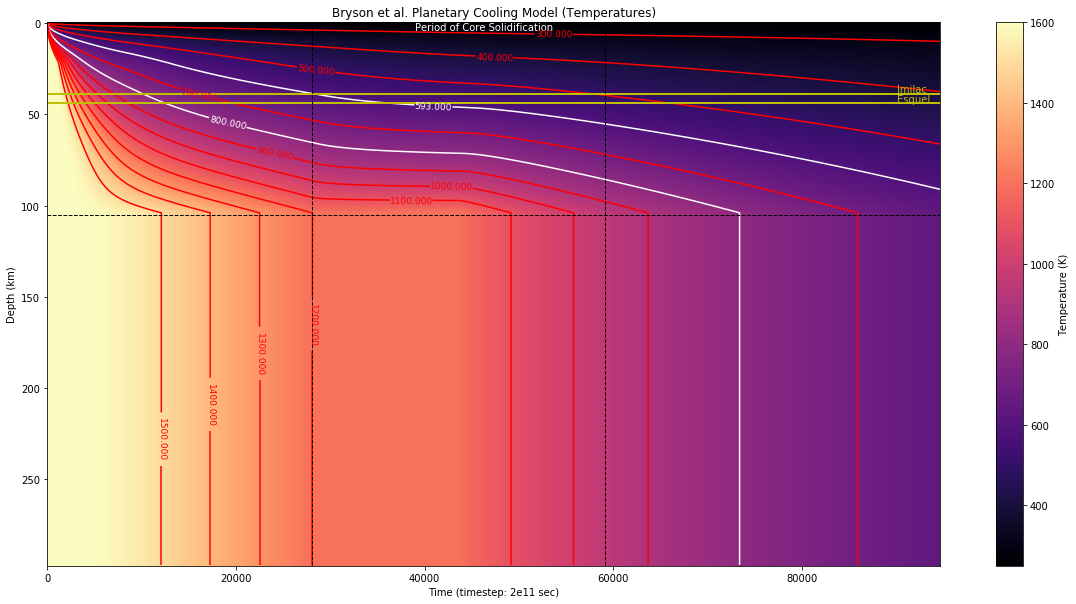

In [12]:
#Temperature Plot

fig, ax = plt.subplots(figsize=(20,10))

im = ax.imshow(np.concatenate((temperatures[-1:0:-1,:],coretemp[-1:0:-1,:]),axis=0), aspect='auto', cmap='magma')


ax.set_xlabel("Time (timestep: 2e11 sec)")
ax.set_ylabel("Depth (km)")

levels = [100, 200, 300, 400, 500, 593, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500] #contour lines

cont_temps = plt.contour(np.concatenate((temperatures[-1:0:-1,:],coretemp[-1:0:-1,:]),axis=0), levels, colors=['r','r','r','w','r','w','r','r','r','r','r','r','r','r','r'])
plt.clabel(cont_temps, fontsize=9, inline=1)

#plot lines and text labels
#plot Depth lines 
if Esquel_Depth == 0 or Esquel_Depth == (r_core/1000) or Esquel_Depth is None:
    pass
else:
    ax.plot([0,max_time/(10**11)/2],[Esquel_Depth, Esquel_Depth], lw=2, c="y", linestyle='-')
    plt.text((max_time/(10**11)/2.1),Esquel_Depth-1,'Esquel', color= 'y')

if Imilac_Depth == 0 or Imilac_Depth == (r_core/1000) or Imilac_Depth is None:
    pass
else:
    ax.plot([0,max_time/(10**11)/2],[Imilac_Depth,Imilac_Depth], lw=2, c="y", linestyle='-')
    plt.text((max_time/(10**11)/2.1),Imilac_Depth-1,'Imilac', color='y')

#plot core lines if frozen before max time 
if time_core_frozen==0 or fully_frozen==0:
    pass
else:
    #core begins to freeze line
    ax.plot([time_core_frozen/(10**11),time_core_frozen/(10**11)],[((r_planet)/1000)-3,0], lw=1, c="k",linestyle= '--')
    #core finishes freezing
    ax.plot([fully_frozen/(10**11),fully_frozen/(10**11)],[((r_planet)/1000)-3,0], lw=1, c="k",linestyle= '--')
    #Core location
    ax.plot([0,max_time/(10**11)/2],[(r_planet/1000)-(r_core/1000),(r_planet/1000)-(r_core/1000)], lw=1, c="k", linestyle='--')
    #Add text labelling period of core solidification
    middle_of_core_solidification = (((fully_frozen+time_core_frozen)/2))/(10**11)-4700
    plt.text(middle_of_core_solidification,4,'Period of Core Solidification', color='w')



plt.title('Bryson et al. Planetary Cooling Model (Temperatures)')


cb = fig.colorbar(im)
cb.set_label('Temperature (K)')
plt.show()

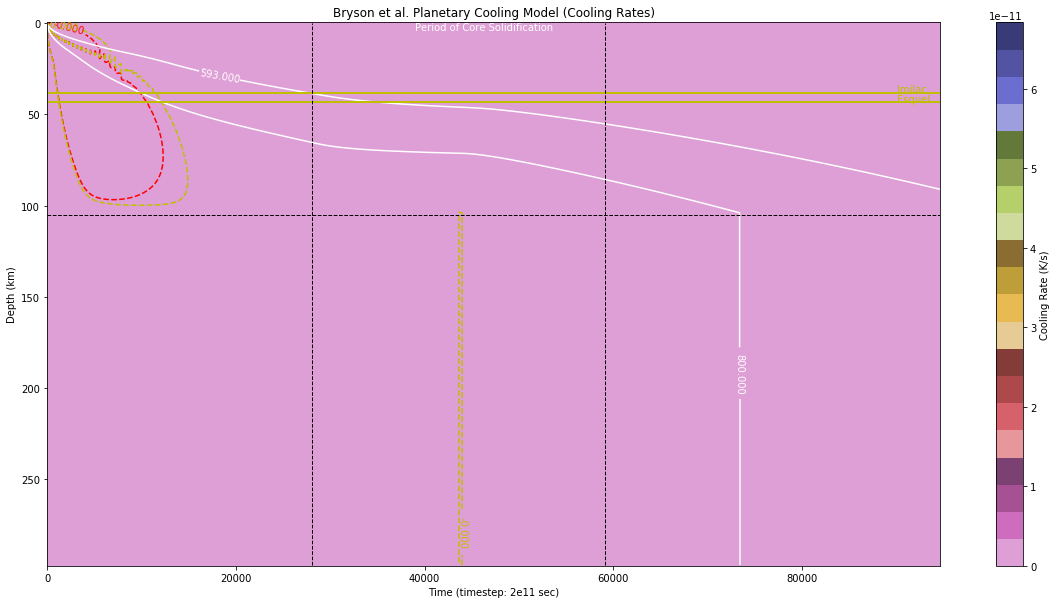

In [13]:
#Cooling Rate Plot

fig, ax = plt.subplots(figsize=(20,10))

im = ax.imshow(np.concatenate((dT_by_dt[-1:0:-1,2:],dT_by_dt_core[-1:0:-1,2:]),axis=0), aspect='auto',vmin=-1E-17 ,cmap='tab20b_r')

ax.set_xlabel("Time (timestep: 2e11 sec)")
ax.set_ylabel("Depth (km)")

#Plot Imilac Cooling Rate Contour
levels = [-(Imilac_cooling_rate)]
cont_Im = plt.contour(np.concatenate((dT_by_dt[-1:0:-1,:],dT_by_dt_core[-1:0:-1,:]),axis=0), levels, colors='r')
plt.clabel(cont_Im, fontsize=10, inline=1, lw=3)

#Plot Esquel Cooling Rate Contour
levels= [-(Esquel_cooling_rate)]
cont_Esq = plt.contour(np.concatenate((dT_by_dt[-1:0:-1,:],dT_by_dt_core[-1:0:-1,:]),axis=0), levels, colors='y')
plt.clabel(cont_Esq, fontsize=10, inline=1, lw=3)

#Plot 593K contour
levels=[593]
cont593 = plt.contour(np.concatenate((temperatures[-1:0:-1,:],coretemp[-1:0:-1,:]),axis=0), levels, colors='w')
plt.clabel(cont593, fontsize=10, inline=1)

#Plot 800K contour
levels=[800]
cont800 = plt.contour(np.concatenate((temperatures[-1:0:-1,:],coretemp[-1:0:-1,:]),axis=0), levels, colors='w')
plt.clabel(cont800, fontsize=10, inline=1)

#plot lines and text labels
#plot Depth lines if in mantle
if Esquel_Depth == 0 or Esquel_Depth == (r_core/1000) or Esquel_Depth is None:
    pass
else:
    ax.plot([0,max_time/(10**11)/2],[Esquel_Depth-0.5, Esquel_Depth-0.5], lw=2, c="y", linestyle='-')
    plt.text((max_time/(10**11)/2.1),Esquel_Depth-1,'Esquel', color= 'y')

if Imilac_Depth == 0 or Imilac_Depth == (r_core/1000) or Imilac_Depth is None:
    pass
else:
    ax.plot([0,max_time/(10**11)/2],[Imilac_Depth-0.5,Imilac_Depth-0.5], lw=2, c="y", linestyle='-')
    plt.text((max_time/(10**11)/2.1),Imilac_Depth-1,'Imilac', color='y')

#plot core lines if frozen before max time
if time_core_frozen==0 or fully_frozen==0:
    pass

else:
    #core begins to freeze line
    ax.plot([time_core_frozen/(10**11),time_core_frozen/(10**11)],[((r_planet)/1000)-3,0], lw=1, c="k",linestyle= '--')
    #core finishes freezing
    ax.plot([fully_frozen/(10**11),fully_frozen/(10**11)],[((r_planet)/1000)-3,0], lw=1, c="k",linestyle= '--')
    #Core location
    ax.plot([0,max_time/(10**11)/2],[(r_planet/1000)-(r_core/1000),(r_planet/1000)-(r_core/1000)], lw=1, c="k", linestyle='--')
    #Add text labelling period of core solidification
    middle_of_core_solidification = (((fully_frozen+time_core_frozen)/2))/(10**11)-4700
    plt.text(middle_of_core_solidification,4,'Period of Core Solidification', color='w')



plt.title('Bryson et al. Planetary Cooling Model (Cooling Rates)')

cb = fig.colorbar(im)
cb.set_label('Cooling Rate (K/s)')
plt.show()


In [14]:
print(np.unravel_index(np.argmin(dT_by_dt), dT_by_dt.shape))

(104, 0)
